In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import math
from math import pi
import time
import scipy as sp
from scipy import stats
from scipy.stats import norm
import scipy.linalg as la
from pandas.tseries.offsets import DateOffset

def process_excel_file(file_name, year):
    # Define the start and end of your time range
    start = pd.Timestamp(f'{year}-01-01 00:00:00')
    end = pd.Timestamp(f'{year}-12-31 23:00:00')
    # Create an hourly time index between start and end
    time_index = pd.date_range(start, end, freq='h')
    # Read the Excel file and select columns
    df = pd.read_excel(file_name, sheet_name='RI', usecols=['RT_Demand', 'Dry_Bulb', 'RT_LMP'])
    # Assign your new time index to your dataframe
    df.index = time_index
    # Convert columns to numpy arrays
    y1 = df['RT_Demand'].to_numpy()
    return y1

def read_file(years):
    y1_list= []
    for year in years:
        file_name = f'{year}_smd_hourly.xlsx'  # Assuming your file name format
        y1 = process_excel_file(file_name, year)
        y1_list.append(y1)
    # Stack the arrays in each list column-wise
    y1 = np.hstack(y1_list)
    return y1

def mask_array_entries_fixed(y1, mask_percentage=20):
    # Ensure reproducibility by setting a random seed
    np.random.seed(42)
    # Ensure the array is of a floating-point type to accommodate NaNs
    y1_float = y1.astype(float)
    y_test = np.full((len(y1),), np.nan, dtype=np.float64)
    # Calculate the number of entries to mask
    total_entries = y1.size
    num_to_mask = int(total_entries * (mask_percentage / 100.0))
    # Generate random indices to mask, excluding the first entry
    possible_indices = np.arange(1, total_entries)  # Start from 1 to exclude the first entry
    mask_indices = np.random.choice(possible_indices, num_to_mask, replace=False)
    # Mask the selected indices with NaNs
    y_test[mask_indices] = y1_float[mask_indices]
    y1_float[mask_indices] = np.nan
    return y1_float, y_test, mask_indices

def fill_missing_with_fwfill(y_train):
    # Copy y_train to not modify the original array
    y_filled = y_train.copy()
    # Automatically identify indices of missing values
    missing_indices = np.where(np.isnan(y_train))[0]
    # Variable to track the last known value; initialized to the first value of y_train
    last_known_value = y_filled[0]
    # Iterate through the array and forward fill the missing values
    for i in range(len(y_filled)):
        if np.isnan(y_filled[i]):
            y_filled[i] = last_known_value  # Replace NaN with the last known value
        else:
            last_known_value = y_filled[i]  # Update the last known value

    return y_filled, missing_indices

def create_future_with_mask(x, val_indices):
    memory = 72
    horizon = 24
    number_of_samples = len(x) - horizon - memory
    future = np.zeros((number_of_samples, horizon))
    mask_future = np.zeros((number_of_samples, horizon), dtype=bool)
    c = 0
    for i in range(memory, len(x) - horizon):
        future_slice = x[i:i+24]
        future[c] = future_slice
        # Create a mask for the current slice based on val_indices
        mask_future[c] = np.isin(range(i, i+24), val_indices)
        c += 1
    return future, ~mask_future

def create_future_without_mask(x):
    memory = 72
    horizon = 24
    number_of_samples = len(x) - horizon - memory
    future = np.zeros((number_of_samples, horizon))
    c = 0
    for i in range(memory, len(x) - horizon):
        future_slice = x[i:i+24]
        future[c] = future_slice
        c += 1
    return future

def create_memory_for_baseline(x):
    memory = int(24*14)
    horizon = 24
    number_of_samples = len(x) - horizon - memory
    past = np.zeros((number_of_samples,memory))
    c=0
    for i in range(memory, len(x)-horizon):
        past[c,:memory] = x[i - memory : i]
        c+=1
    return past

def create_future_for_baseline(x):
    memory = int(24*14)
    horizon = 24
    number_of_samples = len(x) - horizon - memory
    future = np.zeros((number_of_samples, horizon))
    c = 0
    for i in range(memory, len(x) - horizon):
        future_slice = x[i:i+24]
        future[c] = future_slice
        c += 1
    return future

def rolling_forecaster(past, horizon=24, memory=336, percentile=50):
    # Number of samples in the past data
    number_of_samples = past.shape[0]
    # Initialize the forecasts array
    forecasts = np.zeros((number_of_samples, horizon))
    # Number of days to look back
    days_back = memory // 24
    # Loop over each hour in the forecast horizon
    for hour in range(horizon):
        # Extract the corresponding hour from each day in the past
        indices = np.arange(hour, memory, 24)
        relevant_hours = past[:, indices]
        # Calculate the specified percentile for each sample
        forecasts[:, hour] = np.percentile(relevant_hours, percentile, axis=1)
    return forecasts

def inference_baseline(f, f_hat, Mask,):
    # Compute the residual
    residual = f - f_hat
    # Compute the absolute error
    abs_error = np.abs(residual)
    # Invert the mask: True for values we want to include
    valid_mask = ~Mask
    # Initialize an array to hold the AAE for each horizon
    aae_per_horizon = np.zeros(f.shape[1])
    # Calculate AAE for each horizon considering only unmasked (valid) entries
    for i in range(f.shape[1]):  # Iterate over each column (horizon)
        # Select the column and apply the mask
        valid_errors = abs_error[:, i][valid_mask[:, i]]
        # Calculate the mean of the absolute errors for the valid entries
        if valid_errors.size > 0:  # Check to avoid division by zero
            aae_per_horizon[i] = np.mean(valid_errors)
        else:
            aae_per_horizon[i] = np.nan  # Use NaN to indicate no valid entries for this horizon   
    return aae_per_horizon

train_years = [2020, 2021]
test_years = [2022]
validation_data_percentage = 30
y_in_sample = read_file(train_years)
y_out_sample = read_file(test_years)
y_train, y_val, val_indices = mask_array_entries_fixed(y_in_sample, validation_data_percentage)
y_train_fwfill, _ = fill_missing_with_fwfill(y_train)
train_standardization_mean = np.mean(y_train_fwfill)
train_standardization_std = np.std(y_train_fwfill)
y_train_fwfill_std = (y_train_fwfill-train_standardization_mean)/train_standardization_std
in_sample_standardization_mean = np.mean(y_in_sample)
in_sample_standardization_std = np.std(y_in_sample)
y_in_sample_std = (y_in_sample-in_sample_standardization_mean)/in_sample_standardization_std

out_sample_standardization_mean = np.mean(y_out_sample)
out_sample_standardization_std = np.std(y_out_sample)
y_out_sample_std = (y_out_sample-in_sample_standardization_mean)/in_sample_standardization_std

future_y_train_fwfill_std , mask_future_y_train_fwfill_std = create_future_with_mask(y_train_fwfill_std, val_indices) #future_y_train_fwfill_std
future_y_in_sample_std = create_future_without_mask(y_in_sample_std)
future_y_out_sample_std = create_future_without_mask(y_out_sample_std)
#No need to standardize for baseline experiments
past_baseline = create_memory_for_baseline(y_out_sample)
future_baseline = create_future_for_baseline(y_out_sample)

<Figure size 800x75 with 0 Axes>

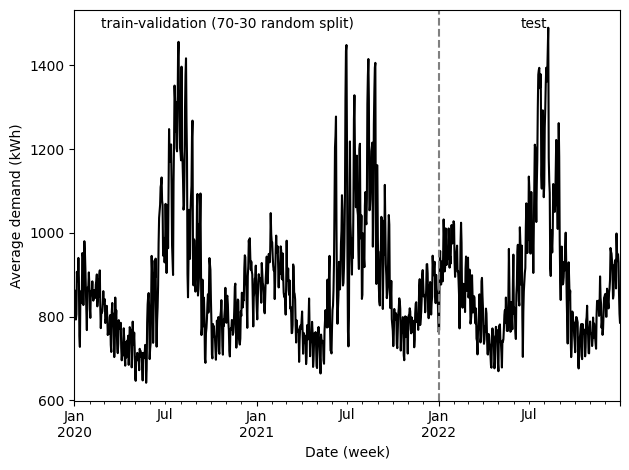

In [4]:
#Figure 1 of paper
y = np.hstack([y_in_sample,y_out_sample])
time_index = pd.date_range(start='2020-01-01 00:00', end='2022-12-31 23:00', freq='h')
df = pd.DataFrame(y, index=time_index, columns=['Data'])
daily_average = df.resample('D').mean()
plt.figure(figsize=(8, 0.75))
daily_average.plot(color='black', legend=False)
plt.ylabel('Average demand (kWh)')
plt.xlabel('Date (week)')
plt.axvline(pd.Timestamp('2022-01-01'), color='gray', linestyle='--')
plt.text(pd.Timestamp('2021-07-15'), max(daily_average['Data']), 'train-validation (70-30 random split)', horizontalalignment='right', color='black')
plt.text(pd.Timestamp('2022-06-15'), max(daily_average['Data']), 'test', horizontalalignment='left', color='black')
plt.tight_layout()
plt.grid(False)
plt.savefig('data_at_macro_scale.pdf')
plt.show()

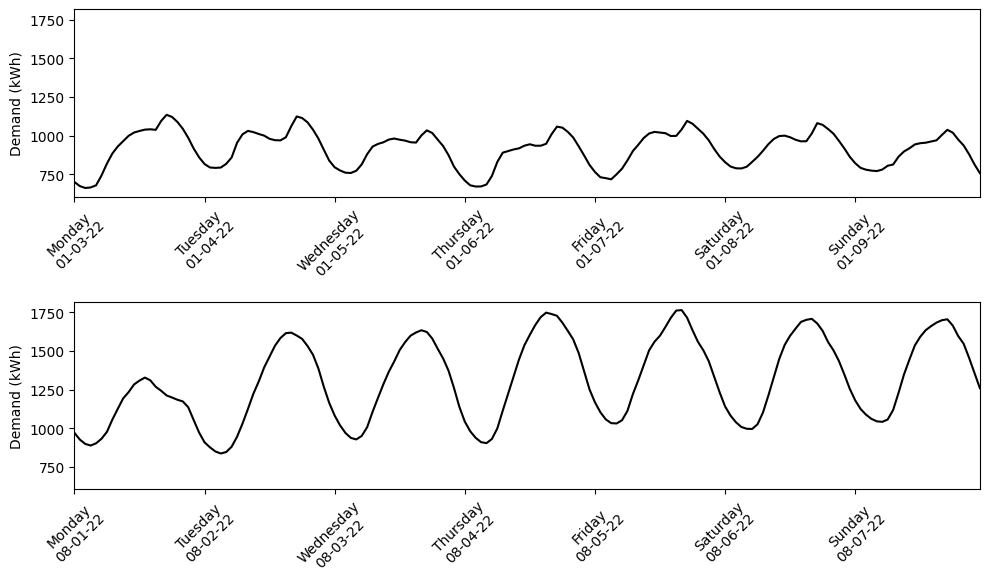

In [6]:
#Figure 2 of paper
time_range = pd.date_range(start="01-01-2022 00:00", end="12-31-2022 23:00", freq='h')
df = pd.DataFrame({'Demand': y_out_sample}, index=time_range)
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)

# Plot the data for January 3 to 9
df["2022-01-03":"2022-01-09"].plot(ax=axes[0], legend=False, color='black', linewidth=1.5)
axes[0].set_ylabel("Demand (kWh)")
axes[0].set_xticks(df["2022-01-03":"2022-01-09"].index[::24])
axes[0].set_xticklabels([f"Monday\n01-03-22", "Tuesday\n01-04-22", "Wednesday\n01-05-22", 
                         "Thursday\n01-06-22", "Friday\n01-07-22", "Saturday\n01-08-22", 
                         "Sunday\n01-09-22"], rotation=45, ha="center")
axes[0].grid(False)
# Plot the data for August 1 to 7
df["2022-08-01":"2022-08-07"].plot(ax=axes[1], legend=False, color='black', linewidth=1.5)
axes[1].set_ylabel("Demand (kWh)")
axes[1].set_xticks(df["2022-08-01":"2022-08-07"].index[::24])
axes[1].set_xticklabels([f"Monday\n08-01-22", "Tuesday\n08-02-22", "Wednesday\n08-03-22", 
                         "Thursday\n08-04-22", "Friday\n08-05-22", "Saturday\n08-06-22", 
                         "Sunday\n08-07-22"], rotation=45, ha="center")
plt.tight_layout()
plt.grid(False)
plt.savefig('data_at_micro_scale.pdf')
plt.show()

In [7]:
def individual_bases(K1,K2,K3,T_start,T,P1,P2,P3):
    w1 = 2*pi/P1
    w2 = 2*pi/P2
    w3 = 2*pi/P3
    Base=np.zeros((T,(2*K1)+(2*K2)+(2*K3)+1))
    c=0
    for t in range(T_start,T_start+T):
        Basis=[1]
        for i in range(1,K1+1):
            Basis.append(math.cos(i*w1*t))
            Basis.append(math.sin(i*w1*t))
        for i in range(1,K2+1):
            Basis.append(math.cos(i*w2*t))
            Basis.append(math.sin(i*w2*t))
        for i in range(1,K3+1):
            Basis.append(math.cos(i*w3*t))
            Basis.append(math.sin(i*w3*t))
        Base[c,:]=Basis
        c+=1
    B_P0 = Base[:,0].reshape(-1,1)
    B_P1 = Base[:,1:(2*K1)+1]
    B_P2 = Base[:,(2*K1)+1:(2*K2)+(2*K1+1)]
    B_P3 = Base[:,(2*K2)+(2*K1+1):(2*K3)+(2*K2)+(2*K1+1)]
    Bases = [B_P0,B_P1,B_P2,B_P3]
    return Bases #(P1,3*2K+1)

def cross_bases(B_P1, B_P2):
    outer_products = [np.outer(B_P1[i], B_P2[i]).flatten().reshape(-1,1) for i in range(B_P1.shape[0])]
    result = np.concatenate(outer_products, axis=1).T
    return result

def basis_with_cross_terms(K1,K2,K3,T_start,T,P1,P2,P3):
    Bases = individual_bases(K1,K2,K3,T_start,T,P1,P2,P3)
    B_P0 = Bases[0]
    B_P1 = Bases[1]
    B_P2 = Bases[2]
    B_P3 = Bases[3]
    C_12 = cross_bases(B_P1,B_P2)
    C_13 = cross_bases(B_P1,B_P3)
    C_23 = cross_bases(B_P2,B_P3)
    B = np.hstack([B_P0,B_P1,B_P2,B_P3,C_12,C_13,C_23])
    return B

def basis_with_additive_terms(K1,K2,K3,T_start,T,P1,P2,P3):
    Bases = individual_bases(K1,K2,K3,T_start,T,P1,P2,P3)
    B_P0 = Bases[0]
    B_P1 = Bases[1]
    B_P2 = Bases[2]
    B_P3 = Bases[3]
    B = np.hstack([B_P0,B_P1,B_P2,B_P3])
    return B

def create_past_with_basis(x,B):
    memory = 72
    horizon = 24
    number_of_samples = len(x)-horizon-memory
    past = np.zeros((number_of_samples,memory+B.shape[1]))
    c=0
    for i in range(memory, len(x)-horizon):
        past[c,:memory] = x[i - memory : i]
        past[c,memory:] = B[i-1]
        c+=1
    return past

def create_past_without_basis(x):
    memory = 72
    horizon = 24
    number_of_samples = len(x)-horizon-memory
    past = np.zeros((number_of_samples,memory))
    c=0
    for i in range(memory, len(x)-horizon):
        past[c,:memory] = x[i - memory : i]
        c+=1
    return past

def create_past_without_memory(x, B):
    memory = 72
    horizon = 24
    number_of_samples = len(x)-horizon-memory
    past = np.zeros((number_of_samples,B.shape[1]))
    c=0
    for i in range(memory, len(x)-horizon):
        past[c,:B.shape[1]] = B[i-1]
        c+=1
    return past

P1 = 365.24225*24
P2 = 7*24
P3 = 24
K = [2,3,4]

Bc_in_sample = basis_with_cross_terms(K[0],K[1],K[2],0,len(y_in_sample),P1,P2,P3)
Ba_in_sample = basis_with_additive_terms(K[0],K[1],K[2],0,len(y_in_sample),P1,P2,P3)
Bc_out_sample = basis_with_cross_terms(K[0],K[1],K[2],len(y_in_sample),len(y_out_sample),P1,P2,P3)
Ba_out_sample = basis_with_additive_terms(K[0],K[1],K[2],len(y_in_sample),len(y_out_sample),P1,P2,P3)

past_y_train_fwfill_stdc = create_past_with_basis(y_train_fwfill_std,Bc_in_sample)
past_y_in_sample_stdc = create_past_with_basis(y_in_sample_std,Bc_in_sample)
past_y_out_sample_stdc = create_past_with_basis(y_out_sample_std,Bc_out_sample)

past_y_train_fwfill_stda = create_past_with_basis(y_train_fwfill_std,Ba_in_sample)
past_y_in_sample_stda = create_past_with_basis(y_in_sample_std,Ba_in_sample)
past_y_out_sample_stda = create_past_with_basis(y_out_sample_std,Ba_out_sample)

past_y_train_fwfill_stdp = create_past_without_basis(y_train_fwfill_std)
past_y_in_sample_stdp = create_past_without_basis(y_in_sample_std)
past_y_out_sample_stdp = create_past_without_basis(y_out_sample_std)

past_y_train_fwfill_stdt = create_past_without_memory(y_train_fwfill_std,Bc_in_sample)
past_y_in_sample_stdt = create_past_without_memory(y_in_sample_std,Bc_in_sample)
past_y_out_sample_stdt = create_past_without_memory(y_out_sample_std,Bc_out_sample)

In [18]:
def create_regularization_timec(K,theta,mem1):
    lambdas_time = cp.Parameter(3,nonneg=True)
    period1 = np.tile(np.repeat(np.arange(1, K[0] + 1), 2), 1)#*lambdas[0]
    period2 = np.tile(np.repeat(np.arange(1, K[1] + 1), 2), 1)#*lambdas[1]
    period3 = np.tile(np.repeat(np.arange(1, K[2] + 1), 2), 1)#*lambdas[2]
    period12 = np.tile(np.repeat(np.arange(1, K[1] + 1), 2), 2*K[0])#*lambdas[1]
    period13 = np.tile(np.repeat(np.arange(1, K[2] + 1), 2), 2*K[0])#*lambdas[2]
    period23 = np.tile(np.repeat(np.arange(1, K[2] + 1), 2), 2*K[1])#*lambdas[2]
    r_period1= lambdas_time[0]*cp.sum_squares(np.diag(period1)@theta[mem1:(mem1+len(period1))])
    r_period2= lambdas_time[1]*cp.sum_squares(np.diag(period2)@theta[(mem1+len(period1)):(mem1+len(period1)+len(period2))])
    r_period3= lambdas_time[2]*cp.sum_squares(np.diag(period3)@theta[(mem1+len(period1)+len(period2)):(mem1+len(period1)+len(period2)+len(period3))])
    r_period12= lambdas_time[1]*cp.sum_squares(np.diag(period12)@theta[(mem1+len(period1)+len(period2)+len(period3)):(mem1+len(period1)+len(period2)+len(period3)+len(period12))])
    r_period13= lambdas_time[2]*cp.sum_squares(np.diag(period13)@theta[(mem1+len(period1)+len(period2)+len(period3)+len(period12)):(mem1+len(period1)+len(period2)+len(period3)+len(period12)+len(period13))])
    r_period23= lambdas_time[2]*cp.sum_squares(np.diag(period23)@theta[(mem1+len(period1)+len(period2)+len(period3)+len(period12)+len(period13)):(mem1+len(period1)+len(period2)+len(period3)+len(period12)+len(period13)+len(period23))])
    regularization_time = r_period1 + r_period2 + r_period3 + r_period12 + r_period13 + r_period23
    return regularization_time

def create_regularization_timea(K,theta,mem1):
    lambdas_time = cp.Parameter(3,nonneg=True)
    period1 = np.tile(np.repeat(np.arange(1, K[0] + 1), 2), 1)#*lambdas[0]
    period2 = np.tile(np.repeat(np.arange(1, K[1] + 1), 2), 1)#*lambdas[1]
    period3 = np.tile(np.repeat(np.arange(1, K[2] + 1), 2), 1)#*lambdas[2]
    r_period1= lambdas_time[0]*cp.sum_squares(np.diag(period1)@theta[mem1:(mem1+len(period1))])
    r_period2= lambdas_time[1]*cp.sum_squares(np.diag(period2)@theta[(mem1+len(period1)):(mem1+len(period1)+len(period2))])
    r_period3= lambdas_time[2]*cp.sum_squares(np.diag(period3)@theta[(mem1+len(period1)+len(period2)):(mem1+len(period1)+len(period2)+len(period3))])
    regularization_time = r_period1 + r_period2 + r_period3
    return regularization_time

def create_regularization_past(theta,mem1):
    lambda_past = cp.Parameter(1, nonneg=True)
    regularization_past = lambda_past*cp.sum_squares(theta[:(mem1-1)])
    return regularization_past

def problemc(f, p, Mask, K, eta):
    mem1=72+1
    theta = cp.Variable((p.shape[1],24))
    numeric_mask = Mask.astype(float)
    actual = f
    estimation = p @ theta
    residual = actual - estimation
    main_loss_expression = 0.5 * cp.abs(residual) + (eta-0.5)*(residual)
    masked_loss_expression = cp.sum(cp.multiply(main_loss_expression, numeric_mask))
    regularization_past = create_regularization_past(theta,mem1)
    regularization_time = create_regularization_timec(K,theta,mem1)
    obj = masked_loss_expression + regularization_time + regularization_past
    prob = cp.Problem(cp.Minimize(obj))
    return prob

def problema(f, p, Mask, K, eta):
    mem1=72+1
    theta = cp.Variable((p.shape[1],24))
    numeric_mask = Mask.astype(float)
    actual = f
    estimation = p @ theta
    residual = actual - estimation
    main_loss_expression = 0.5 * cp.abs(residual) + (eta-0.5)*(residual)
    masked_loss_expression = cp.sum(cp.multiply(main_loss_expression, numeric_mask))
    regularization_past = create_regularization_past(theta,mem1)
    regularization_time = create_regularization_timea(K,theta,mem1)
    obj = masked_loss_expression + regularization_time + regularization_past
    prob = cp.Problem(cp.Minimize(obj))
    return prob

def problemp(f, p, Mask, eta):
    mem1=72+1
    theta = cp.Variable((p.shape[1],24))
    numeric_mask = Mask.astype(float)
    actual = f
    estimation = p @ theta
    residual = actual - estimation
    main_loss_expression = 0.5 * cp.abs(residual) + (eta-0.5)*(residual)
    masked_loss_expression = cp.sum(cp.multiply(main_loss_expression, numeric_mask))
    regularization_past = create_regularization_past(theta,mem1)
    obj = masked_loss_expression + regularization_past
    prob = cp.Problem(cp.Minimize(obj))
    return prob

def problemt(f, p, Mask, K, eta):
    mem1=0+1 #no memory
    theta = cp.Variable((p.shape[1],24))
    numeric_mask = Mask.astype(float)
    actual = f
    estimation = p @ theta
    residual = actual - estimation
    main_loss_expression = 0.5 * cp.abs(residual) + (eta-0.5)*(residual)
    masked_loss_expression = cp.sum(cp.multiply(main_loss_expression, numeric_mask))
    regularization_time = create_regularization_timec(K,theta,mem1)
    obj = masked_loss_expression + regularization_time
    prob = cp.Problem(cp.Minimize(obj))
    return prob

def inference(f, p, Mask, theta, mu, sigma):
    actual = f * sigma + mu
    estimation = (p @ theta) * sigma + mu
    residual = actual - estimation
    abs_error = np.abs(residual)
    valid_mask = ~Mask
    aae_per_horizon = np.zeros(actual.shape[1])
    for i in range(actual.shape[1]): 
        valid_errors = abs_error[:, i][valid_mask[:, i]]
        if valid_errors.size > 0:
            aae_per_horizon[i] = np.mean(valid_errors)
        else:
            aae_per_horizon[i] = np.nan
    return aae_per_horizon

def cyclical_greedy_search(prob, f_in_sample, p_in_sample, mask_in_sample, mu, sigma, eta, lower_limit, upper_limit, max_iter=100):
    """
    Perform a cyclical greedy search, taking into account directional improvements and avoiding out-of-bound parameter adjustments.
    """
    # Retrieve and prepare parameters
    time_params = prob.parameters()[0].value
    past_param = prob.parameters()[1].value[0]
    
    print("Trying initial solve")
    aae_overall, solve_time = solve_and_evaluate(prob, f_in_sample, p_in_sample, mask_in_sample, mu, sigma)
    print(f"Initial solve time: {solve_time:.2f} seconds, Initial AAE: {aae_overall:.4f}")
    history = [(aae_overall, time_params.copy(), past_param)]
    best_aae_overall = 39.99#aae_overall
    for epoch in range(1, max_iter + 1):
        print(f"\nStarting epoch {epoch}")
        epoch_improvement = False

        # Time parameters
        for i, current_value in enumerate(time_params):
            parameter_change_accepted = False
            for direction_factor, direction_name in [(eta, "increasing"), (1/eta, "decreasing")]:
                new_value = current_value * direction_factor
                # Skip if new value is out of bounds
                if new_value < lower_limit or new_value > upper_limit:
                    print(f"Parameter {i+1} {direction_name} out of bounds, skipping.")
                    continue
                
                time_params[i] = new_value
                prob.parameters()[0].value = time_params
                
                aae_overall, solve_time = solve_and_evaluate(prob, f_in_sample, p_in_sample, mask_in_sample, mu, sigma)
                print(f"Solve time for {direction_name} parameter {i+1}: {solve_time:.2f} seconds, AAE: {aae_overall:.4f}")

                # Check for directional improvement
                percentage_change = (aae_overall - best_aae_overall) / best_aae_overall * 100
                if (direction_name == "increasing" and percentage_change <= 1) or (direction_name == "decreasing" and percentage_change <= -1):
                    print(f"Accepted {direction_name} adjustment: AAE improved to {aae_overall:.4f}")
                    print(f"Time parameter {i+1} is now {new_value:.4f}")
                    best_aae_overall = min(aae_overall, best_aae_overall)
                    epoch_improvement = True
                    parameter_change_accepted = True
                    history.append((aae_overall, time_params.copy(), past_param))
                    break
                else:
                    print(f"No sufficient improvement with {direction_name}, reverting to original value.")
                    print(f"Time parameter {i+1} is left as {current_value:.4f}")
                    history.append((aae_overall, time_params.copy(), past_param))
                    time_params[i] = current_value  # Revert if no improvement
                    
            if parameter_change_accepted == False:
                print(f"No parameter change was accepted for {i+1}th time parameter so recalculating AAE with previous parameters")
                aae_overall, solve_time = solve_and_evaluate(prob, f_in_sample, p_in_sample, mask_in_sample, mu, sigma)
                print(f"Solve time for no change time parameter: {solve_time:.2f} seconds, AAE: {aae_overall:.4f}")
                history.append((aae_overall, time_params.copy(), past_param))

        # Past parameter
        parameter_change_accepted = False
        for direction_factor, direction_name in [(eta, "increasing"), (1/eta, "decreasing")]:
            new_value = past_param * direction_factor
            if new_value < lower_limit or new_value > upper_limit:
                print(f"Past parameter {direction_name} out of bounds, skipping.")
                continue

            prob.parameters()[1].value[0] = new_value
            aae_overall, solve_time = solve_and_evaluate(prob, f_in_sample, p_in_sample, mask_in_sample, mu, sigma)
            print(f"Solve time for {direction_name} past parameter: {solve_time:.2f} seconds, AAE: {aae_overall:.4f}")

            # Check for directional improvement
            percentage_change = (aae_overall - best_aae_overall) / best_aae_overall * 100
            if (direction_name == "increasing" and percentage_change <= 1) or (direction_name == "decreasing" and percentage_change <= -1):
                print(f"Accepted {direction_name} adjustment: AAE improved to {aae_overall:.4f}")
                print(f"Past parameter is now {prob.parameters()[1].value[0]}")
                past_param = new_value
                best_aae_overall = min(aae_overall, best_aae_overall)
                epoch_improvement = True
                parameter_change_accepted = True
                history.append((aae_overall, time_params.copy(), new_value))
                break
            else:
                print(f"No sufficient improvement with {direction_name}, keeping past parameter at {past_param}.")
                history.append((aae_overall, time_params.copy(), new_value))
                prob.parameters()[1].value[0] = past_param  # Revert if no improvement
                print(f"Past parameter is left as {prob.parameters()[1].value[0]}")
                
        if parameter_change_accepted == False:
            print("No parameter change was accepted for past parameter so recalculating AAE with previous parameters")
            aae_overall, solve_time = solve_and_evaluate(prob, f_in_sample, p_in_sample, mask_in_sample, mu, sigma)
            print(f"Solve time for no change past parameter: {solve_time:.2f} seconds, AAE: {aae_overall:.4f}")
            history.append((aae_overall, time_params.copy(), past_param))

        print(f"History so far at epoch {epoch}")
        print(f"{history}\n")
        if not epoch_improvement:
            print("No improvements in this epoch, stopping the search.")
            break

    return history

def solve_and_evaluate(prob, f_in_sample, p_in_sample, mask_in_sample, mu, sigma):
    start_time = time.time()
    prob.solve(verbose=False, solver=cp.MOSEK)
    solve_time = time.time() - start_time
    theta = prob.variables()[0].value
    aae_24 = inference(f_in_sample, p_in_sample, mask_in_sample, theta, mu, sigma)
    aae_overall = np.mean(aae_24)
    return aae_overall, solve_time


In [10]:
probc = problemc(future_y_train_fwfill_std, past_y_train_fwfill_stdc, mask_future_y_train_fwfill_std, K, 0.5)

In [11]:
probc.parameters()[0].value = [1,1,1]
probc.parameters()[1].value = [1]
print(probc.parameters()[0].value)
print(probc.parameters()[1].value)

[1. 1. 1.]
[1.]


In [12]:
eta = 10
lower_limit = 0.001
upper_limit = 1000
max_iter = 100
history_eta_10 = cyclical_greedy_search(probc, future_y_in_sample_std, past_y_in_sample_stdc, mask_future_y_train_fwfill_std, in_sample_standardization_mean,in_sample_standardization_std, eta, lower_limit, upper_limit, max_iter)

Trying initial solve
Initial solve time: 154.29 seconds, Initial AAE: 39.9906

Starting epoch 1
Solve time for increasing parameter 1: 92.71 seconds, AAE: 39.9889
Accepted increasing adjustment: AAE improved to 39.9889
Time parameter 1 is now 10.0000
Solve time for increasing parameter 2: 92.84 seconds, AAE: 39.9847
Accepted increasing adjustment: AAE improved to 39.9847
Time parameter 2 is now 10.0000
Solve time for increasing parameter 3: 89.72 seconds, AAE: 40.0282
Accepted increasing adjustment: AAE improved to 40.0282
Time parameter 3 is now 10.0000
Solve time for increasing past parameter: 88.65 seconds, AAE: 40.0684
Accepted increasing adjustment: AAE improved to 40.0684
Past parameter is now 10.0
History so far at epoch 1
[(39.99056496569873, array([1., 1., 1.]), 1.0), (39.988876545371596, array([10.,  1.,  1.]), 1.0), (39.98469314370711, array([10., 10.,  1.]), 1.0), (40.02817308390434, array([10., 10., 10.]), 1.0), (40.06839382844042, array([10., 10., 10.]), 10.0)]


Starting

In [13]:
len(history_eta_10)

25

In [14]:
print(probc.parameters()[0].value)
print(probc.parameters()[1].value)

[100. 100.  10.]
[10.]


In [15]:
eta = np.sqrt(10)
lower_limit = 0.001
upper_limit = 1000
max_iter = 200
history_eta_3 = cyclical_greedy_search(probc, future_y_in_sample_std, past_y_in_sample_stdc, mask_future_y_train_fwfill_std, in_sample_standardization_mean,in_sample_standardization_std, eta, lower_limit, upper_limit, max_iter)

Trying initial solve
Initial solve time: 87.12 seconds, Initial AAE: 40.0689

Starting epoch 1
Solve time for increasing parameter 1: 88.61 seconds, AAE: 40.2637
Accepted increasing adjustment: AAE improved to 40.2637
Time parameter 1 is now 316.2278
Solve time for increasing parameter 2: 90.11 seconds, AAE: 40.3017
Accepted increasing adjustment: AAE improved to 40.3017
Time parameter 2 is now 316.2278
Solve time for increasing parameter 3: 91.72 seconds, AAE: 40.4326
Accepted increasing adjustment: AAE improved to 40.4326
Time parameter 3 is now 31.6228
Solve time for increasing past parameter: 91.42 seconds, AAE: 40.5209
No sufficient improvement with increasing, keeping past parameter at 10.0.
Past parameter is left as 10.0
Solve time for decreasing past parameter: 91.31 seconds, AAE: 40.4078
No sufficient improvement with decreasing, keeping past parameter at 10.0.
Past parameter is left as 10.0
No parameter change was accepted for past parameter so recalculating AAE with previous

In [16]:
len(history_eta_3)

17

In [17]:
print(probc.parameters()[0].value)
print(probc.parameters()[1].value)

[316.22776602 316.22776602  31.6227766 ]
[10.]


In [19]:
eta = np.sqrt(np.sqrt(10))
lower_limit = 0.001
upper_limit = 1000
max_iter = 200
history_eta_2 = cyclical_greedy_search(probc, future_y_in_sample_std, past_y_in_sample_stdc, mask_future_y_train_fwfill_std, in_sample_standardization_mean,in_sample_standardization_std, eta, lower_limit, upper_limit, max_iter)

Trying initial solve
Initial solve time: 89.93 seconds, Initial AAE: 40.4326

Starting epoch 1
Solve time for increasing parameter 1: 91.38 seconds, AAE: 40.6325
No sufficient improvement with increasing, reverting to original value.
Time parameter 1 is left as 316.2278
Solve time for decreasing parameter 1: 90.83 seconds, AAE: 40.3033
No sufficient improvement with decreasing, reverting to original value.
Time parameter 1 is left as 316.2278
No parameter change was accepted for 1th time parameter so recalculating AAE with previous parameters
Solve time for no change time parameter: 92.30 seconds, AAE: 40.4326
Solve time for increasing parameter 2: 91.29 seconds, AAE: 40.5473
No sufficient improvement with increasing, reverting to original value.
Time parameter 2 is left as 316.2278
Solve time for decreasing parameter 2: 92.47 seconds, AAE: 40.4021
No sufficient improvement with decreasing, reverting to original value.
Time parameter 2 is left as 316.2278
No parameter change was accept

In [20]:
print(probc.parameters()[0].value)
print(probc.parameters()[1].value)

[316.22776602 316.22776602  31.6227766 ]
[10.]


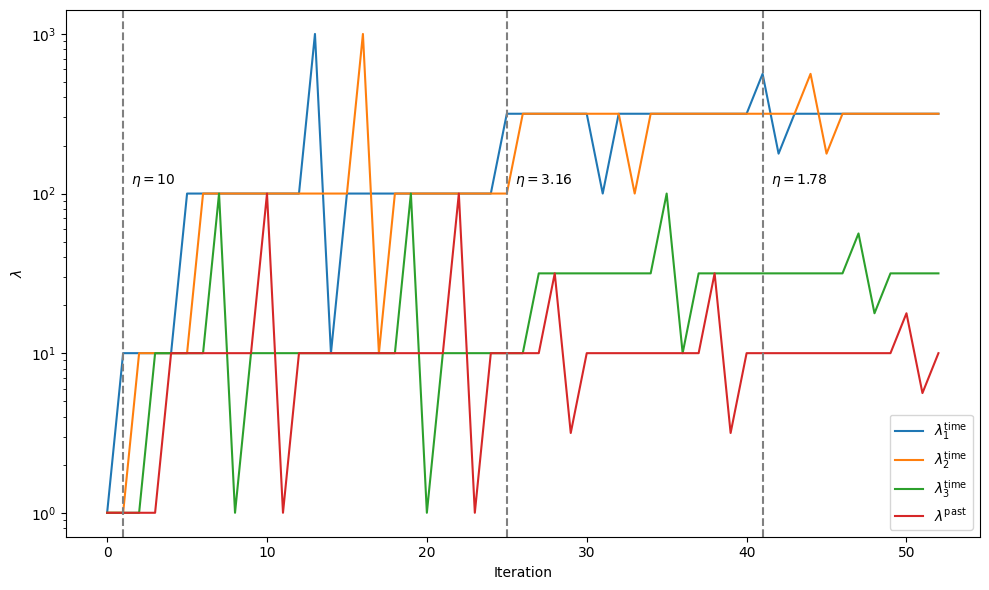

In [43]:
#Figure 3 of paper
import seaborn as sns
histoire = history_eta_10 + history_eta_3[1:] + history_eta_2[1:]
aae_cycle = [histoire[i][0] for i in range(len(histoire))]
lambda_time_1 = [histoire[i][1][0] for i in range(len(histoire))]
lambda_time_2 = [histoire[i][1][1] for i in range(len(histoire))]
lambda_time_3 = [histoire[i][1][2] for i in range(len(histoire))]
lambda_past = [histoire[i][2] for i in range(len(histoire))]
iterations = np.arange(len(lambda_time_1))
colors = sns.color_palette("tab10", n_colors=4)
plt.figure(figsize=(10, 6))
plt.plot(iterations, lambda_time_1, color=colors[0], label=r'$\lambda^{\text{time}}_1$')
plt.plot(iterations, lambda_time_2, color=colors[1], label=r'$\lambda^{\text{time}}_2$')
plt.plot(iterations, lambda_time_3, color=colors[2], label=r'$\lambda^{\text{time}}_3$')
plt.plot(iterations, lambda_past, color=colors[3], label=r'$\lambda^{\text{past}}$')
plt.yscale('log')
plt.ylabel(r"$\lambda$")
plt.xlabel("Iteration")
plt.grid(False)
plt.legend()
vertical_lines = [1, 25, 41]
etas = [r'$\eta=10$', r'$\eta=3.16$', r'$\eta=1.78$']
for line, eta in zip(vertical_lines, etas):
    plt.axvline(x=line, color='gray', linestyle='--')
    plt.text(line+0.5, 10**(np.log10(plt.ylim()[0]) + 1)+100, eta, verticalalignment='bottom', color='black')
plt.tight_layout()
plt.grid(False)
plt.savefig('cyclical_greedy_search_updated.pdf', dpi=300)
plt.show()


In [24]:
mask_in_sample = np.ones(mask_future_y_train_fwfill_std.shape, dtype=bool)
probc = problemc(future_y_in_sample_std, past_y_in_sample_stdc, mask_in_sample, K, 0.5)
probc.parameters()[0].value = [316.22776602,316.22776602,31.6227766]
probc.parameters()[1].value = [10.0]
print(probc.parameters()[0].value)
print(probc.parameters()[1].value)
start_time = time.time()
probc.solve(verbose=False,solver=cp.MOSEK)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")
thetac = probc.variables()[0].value
aaec = inference(future_y_in_sample_std,past_y_in_sample_stdc,mask_future_y_train_fwfill_std,thetac,in_sample_standardization_mean,in_sample_standardization_std)

[316.22776602 316.22776602  31.6227766 ]
[10.]
Execution time: 165.08540391921997 seconds


In [30]:
mask_out_sample = np.zeros(future_y_out_sample_std.shape, dtype=bool)
aaec_out = inference(future_y_out_sample_std,past_y_out_sample_stdc,mask_out_sample,thetac,in_sample_standardization_mean,in_sample_standardization_std)
print(np.mean(aaec_out))

37.08703291858441


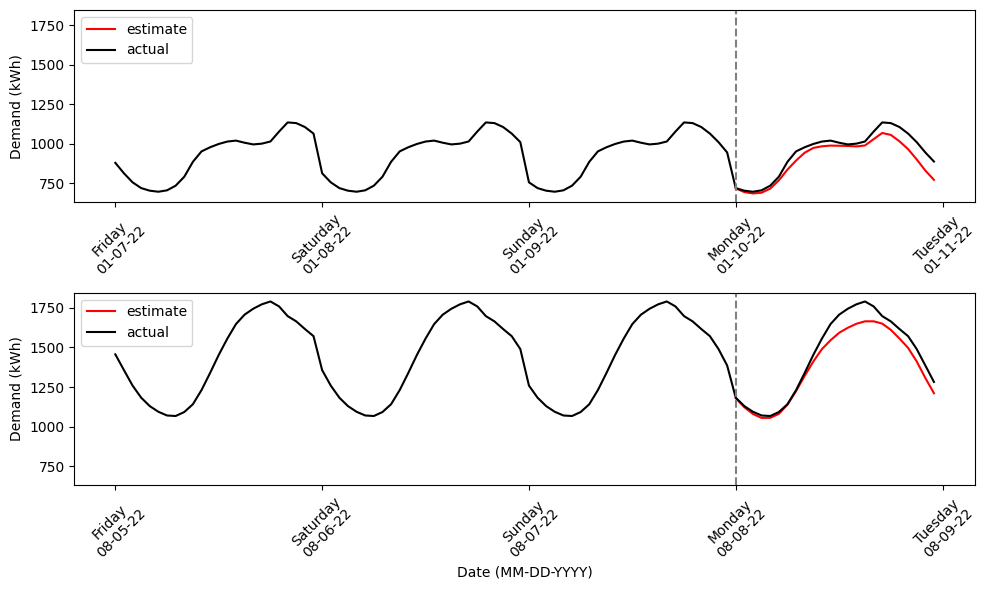

In [26]:
#Figure 5 of the paper
f = future_y_out_sample_std
p = past_y_out_sample_stdc
mu = in_sample_standardization_mean
sigma = in_sample_standardization_std
actual = f * sigma + mu
estimation = (p @ thetac) * sigma + mu

i1 = int(24*9-24*3)
i2 = int(24*219-24*3)

xindex_first_half = range(48+24)
xindex_second_half = range(48+24,72+24)

estimate1 = np.hstack([actual[i1-3],actual[i1-2],actual[i1-1],estimation[i1]])
actual1 = np.hstack([actual[i1-3],actual[i1-2],actual[i1-1],actual[i1]])

estimate2 = np.hstack([actual[i2-3],actual[i2-2],actual[i2-1],estimation[i2]])
actual2 = np.hstack([actual[i2-3],actual[i2-2],actual[i2-1],actual[i2]])

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
axes[0].plot(xindex_second_half,estimate1[48+24:], color="red", label="estimate")
axes[0].plot(actual1, color="black", label="actual")
axes[0].legend(loc='upper left')
axes[0].set_ylabel("Demand (kWh)")
axes[0].grid(False)
axes[0].axvline(48+24, color='gray', linestyle='--')
axes[0].set_xticks([0,24,48,72,96])
axes[0].set_xticklabels([f"Friday\n01-07-22","Saturday\n01-08-22", "Sunday\n01-09-22", "Monday\n01-10-22", "Tuesday\n01-11-22"], rotation=45, ha="center")

axes[1].plot(xindex_second_half,estimate2[48+24:], color="red", label="estimate")
axes[1].plot(actual2, color="black", label="actual")
axes[1].legend(loc='upper left')
axes[1].set_ylabel("Demand (kWh)")
axes[1].set_xlabel("Date (MM-DD-YYYY)")
axes[1].grid(False)
axes[1].axvline(48+24, color='gray', linestyle='--')
axes[1].set_xticks([0,24,48,72,96])
axes[1].set_xticklabels([f"Friday\n08-05-22", "Saturday\n08-06-22", "Sunday\n08-07-22", "Monday\n08-08-22", "Tuesday\n08-09-22"], rotation=45, ha="center")
plt.tight_layout()
fig.savefig('point_forecast.pdf')
plt.show()

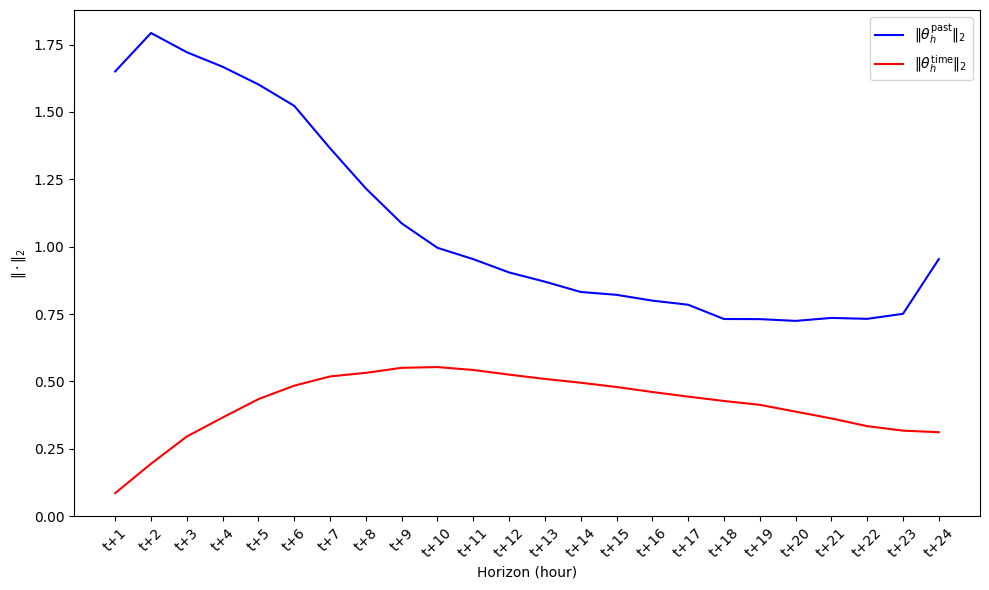

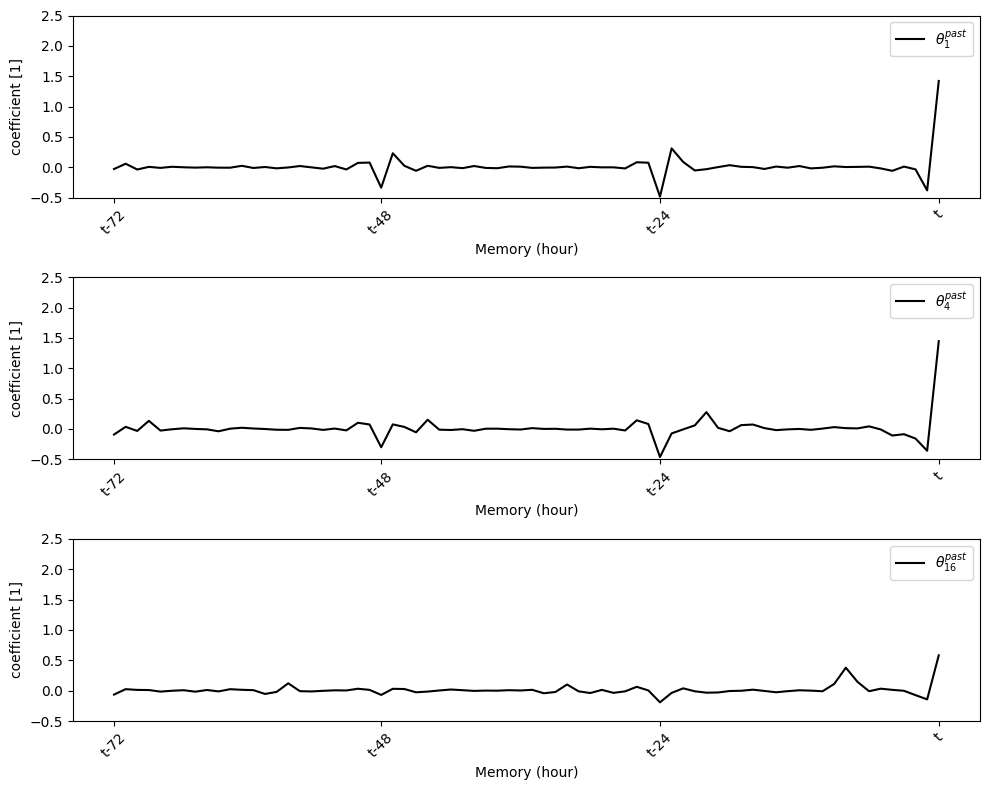

In [27]:
#Figure 7 of paper
memory = 72
num_horizons = 24
# Initialize a 24x2 matrix to store the L2 norms
l2_norms = np.zeros((num_horizons, 3))
for h in range(num_horizons):
    # Extract the median for each horizon
    Theta_median_h = thetac[:, h]
    # Decompose into AR and SMP components
    Theta_median_h_ar = Theta_median_h[:memory]
    Theta_median_h_smp = Theta_median_h[memory:]
    # Calculate L2 norms and store in the matrix
    l2_norms[h, 0] = np.linalg.norm(Theta_median_h_ar, 2)  # L2 norm for AR component
    l2_norms[h, 1] = np.linalg.norm(Theta_median_h_smp, 2)  # L2 norm for SMP component
    l2_norms[h, 2] = np.sqrt(np.linalg.norm(Theta_median_h_ar, 2)**2 + np.linalg.norm(Theta_median_h_smp, 2)**2)

plt.figure(figsize=(10, 6))
plt.plot(l2_norms[:, 0], color='blue', label=r"$\| \theta^{\text{past}}_h \|_2$")
plt.plot(l2_norms[:, 1], color='red', label=r"$\| \theta^{\text{time}}_h \|_2$")
plt.ylabel(r"$\| \cdot \|_2$")
plt.xlabel("Horizon (hour)")
plt.xticks(range(24), [f"t+{i+1}" for i in range(24)], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.savefig("theta_time.pdf")
plt.show()
plt.close()

#Figure 6 of paper
Theta_full_cross_stacked = thetac
memory = 72
# Extracting and rearranging data for different horizons
Theta_median_h1 = Theta_full_cross_stacked[:, 0]
Theta_median_h4 = Theta_full_cross_stacked[:, 3]
Theta_median_h16 = Theta_full_cross_stacked[:, 15]
# AR components
Theta_median_h1_ar = Theta_median_h1[:memory]
Theta_median_h4_ar = Theta_median_h4[:memory]
Theta_median_h16_ar = Theta_median_h16[:memory]
# Set up a 3x1 grid of plots
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
# Plotting data
axs[0].plot(Theta_median_h1_ar, color='black', label = r"$\theta^{past}_{1}$")
axs[1].plot(Theta_median_h4_ar, color='black', label = r"$\theta^{past}_{4}$")
axs[2].plot(Theta_median_h16_ar, color='black', label = r"$\theta^{past}_{16}$")
# Setting x-axis labels and ticks
horizons=[1,4,16]
c=0
for ax in axs[0:]:
    if c==0:
        ax.set_xlabel("Memory (hour)")
        ax.legend()
    elif c==1:
        ax.set_xlabel("Memory (hour)")
        ax.legend()
    else:
        ax.set_xlabel("Memory (hour)")
        ax.legend()
    ax.set_xticks([0, 23, 47, 71])
    ax.set_xticklabels(["t-72", "t-48", "t-24", "t"], rotation=45)
    ax.set_ylabel("coefficient [1]")
    ax.set_ylim([-0.5,2.5])
    ax.grid(False)
    c+=1
plt.tight_layout()
plt.savefig("theta_interpretability.pdf")
plt.show()
plt.close()

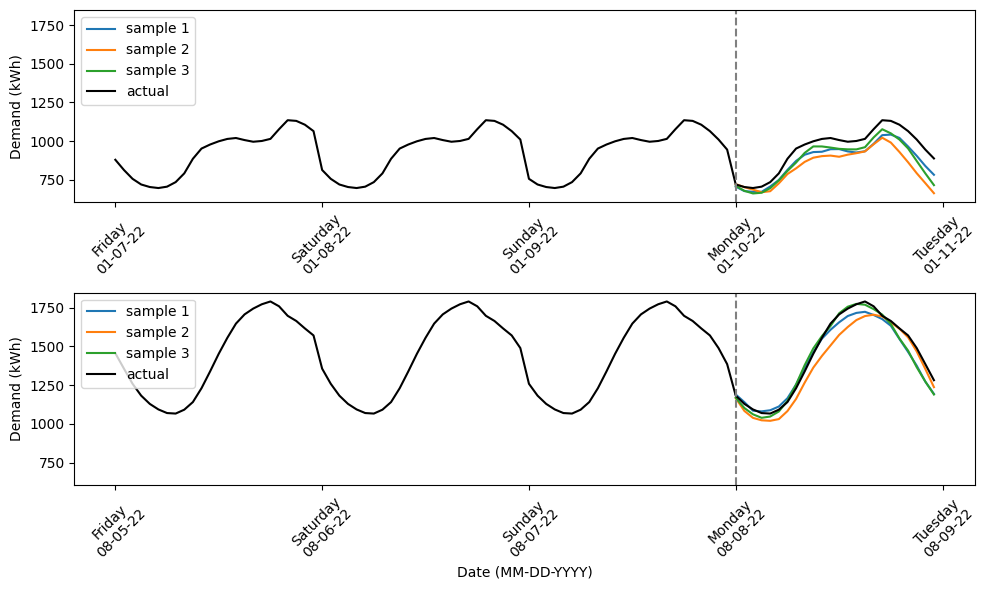

In [28]:
#Figure 10 of paper
f = future_y_in_sample_std
p = past_y_in_sample_stdc
mu = in_sample_standardization_mean
sigma = in_sample_standardization_std
actual_in = f
estimate_in = p @ thetac
residual = actual_in - estimate_in
# Calculate the mean vector and covariance matrix
mean_vec = np.mean(residual, axis=0)
cov_matrix = np.cov(residual, rowvar=False)
# Initialize the multivariate Gaussian distribution
actual = future_y_out_sample_std*sigma+mu
p_out = past_y_out_sample_stdc
estimate_out = past_y_out_sample_stdc@thetac
i1 = int(24*9-24*3)
i2 = int(24*219-24*3)
rv_i1 = stats.multivariate_normal(estimate_out[i1]+mean_vec, cov_matrix)
samples_i1 = rv_i1.rvs(size=3)*sigma+mu
rv_i2 = stats.multivariate_normal(estimate_out[i2]+mean_vec, cov_matrix)
samples_i2 = rv_i2.rvs(size=3)*sigma+mu

xindex_first_half = range(48+24)
xindex_second_half = range(48+24,72+24)


sample1_i1 = np.hstack([actual[i1-3],actual[i1-2],actual[i1-1],samples_i1[0]])
sample2_i1 = np.hstack([actual[i1-3],actual[i1-2],actual[i1-1],samples_i1[1]])
sample3_i1 = np.hstack([actual[i1-3],actual[i1-2],actual[i1-1],samples_i1[2]])
actual1 = np.hstack([actual[i1-3],actual[i1-2],actual[i1-1],actual[i1]])

sample1_i2 = np.hstack([actual[i2-3],actual[i2-2],actual[i2-1],samples_i2[0]])
sample2_i2 = np.hstack([actual[i2-3],actual[i2-2],actual[i2-1],samples_i2[1]])
sample3_i2 = np.hstack([actual[i2-3],actual[i2-2],actual[i2-1],samples_i2[2]])
actual2 = np.hstack([actual[i2-3],actual[i2-2],actual[i2-1],actual[i2]])
colors = sns.color_palette("tab10", n_colors=4)
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
axes[0].plot(xindex_second_half,sample1_i1[48+24:], color=colors[0], label="sample 1")
axes[0].plot(xindex_second_half,sample2_i1[48+24:], color=colors[1], label="sample 2")
axes[0].plot(xindex_second_half,sample3_i1[48+24:], color=colors[2], label="sample 3")
axes[0].plot(actual1, color="black", label="actual")
axes[0].legend(loc='upper left')
axes[0].set_ylabel("Demand (kWh)")
axes[0].grid(False)
axes[0].axvline(48+24, color='gray', linestyle='--')
axes[0].set_xticks([0,24,48,72,96])
axes[0].set_xticklabels([f"Friday\n01-07-22","Saturday\n01-08-22", "Sunday\n01-09-22", "Monday\n01-10-22", "Tuesday\n01-11-22"], rotation=45, ha="center")

axes[1].plot(xindex_second_half,sample1_i2[48+24:], color=colors[0], label="sample 1")
axes[1].plot(xindex_second_half,sample2_i2[48+24:], color=colors[1], label="sample 2")
axes[1].plot(xindex_second_half,sample3_i2[48+24:], color=colors[2], label="sample 3")
axes[1].plot(actual2, color="black", label="actual")
axes[1].legend(loc='upper left')
axes[1].set_ylabel("Demand (kWh)")
axes[1].set_xlabel("Date (MM-DD-YYYY)")
axes[1].grid(False)
axes[1].axvline(48+24, color='gray', linestyle='--')
axes[1].set_xticks([0,24,48,72,96])
axes[1].set_xticklabels([f"Friday\n08-05-22", "Saturday\n08-06-22", "Sunday\n08-07-22", "Monday\n08-08-22", "Tuesday\n08-09-22"], rotation=45, ha="center")
plt.tight_layout()
fig.savefig('generated_samples.pdf')
plt.show()


In [29]:
#Model without cross terms
mask_in_sample = np.ones(mask_future_y_train_fwfill_std.shape, dtype=bool)
proba = problema(future_y_in_sample_std, past_y_in_sample_stda, mask_in_sample, K, 0.5)
proba.parameters()[0].value = [31.622776602,31.622776602,31.6227766]
proba.parameters()[1].value = [10.0]
print(proba.parameters()[0].value)
print(proba.parameters()[1].value)
start_time = time.time()
proba.solve(verbose=False,solver=cp.MOSEK)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")
thetaa = proba.variables()[0].value
aaea = inference(future_y_in_sample_std,past_y_in_sample_stda,mask_future_y_train_fwfill_std,thetaa,in_sample_standardization_mean,in_sample_standardization_std)
mask_out_sample = np.zeros(future_y_out_sample_std.shape, dtype=bool)
aaea_out = inference(future_y_out_sample_std,past_y_out_sample_stda,mask_out_sample,thetaa,in_sample_standardization_mean,in_sample_standardization_std)
print(np.mean(aaea_out))
#Model with only autoregressive features
mask_in_sample = np.ones(mask_future_y_train_fwfill_std.shape, dtype=bool)
probp = problemp(future_y_in_sample_std, past_y_in_sample_stdp, mask_in_sample, 0.5)
probp.parameters()[0].value = [10.0]
print(probp.parameters()[0].value)
start_time = time.time()
probp.solve(verbose=False,solver=cp.MOSEK)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")
thetap = probp.variables()[0].value
aaep = inference(future_y_in_sample_std,past_y_in_sample_stdp,mask_future_y_train_fwfill_std,thetap,in_sample_standardization_mean,in_sample_standardization_std)
mask_out_sample = np.zeros(future_y_out_sample_std.shape, dtype=bool)
aaep_out = inference(future_y_out_sample_std,past_y_out_sample_stdp,mask_out_sample,thetap,in_sample_standardization_mean,in_sample_standardization_std)
print(np.mean(aaep_out))
#Model with only time features
mask_in_sample = np.ones(mask_future_y_train_fwfill_std.shape, dtype=bool)
probt = problemt(future_y_in_sample_std, past_y_in_sample_stdt, mask_in_sample, K, 0.5)
probt.parameters()[0].value = [1,1,1]
print(probt.parameters()[0].value)
start_time = time.time()
probt.solve(verbose=False,solver=cp.MOSEK)
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")
thetat = probt.variables()[0].value
aaet = inference(future_y_in_sample_std,past_y_in_sample_stdt,mask_future_y_train_fwfill_std,thetat,in_sample_standardization_mean,in_sample_standardization_std)
mask_out_sample = np.zeros(future_y_out_sample_std.shape, dtype=bool)
aaet_out = inference(future_y_out_sample_std,past_y_out_sample_stdt,mask_out_sample,thetat,in_sample_standardization_mean,in_sample_standardization_std)
print(np.mean(aaet_out))
#Baseline experiments
forecasts_baseline = rolling_forecaster(past_baseline, percentile=50)
mask_out_sample = np.zeros(future_baseline.shape, dtype=bool)
aaebaseline_out = inference_baseline(future_baseline,forecasts_baseline,mask_out_sample)
print(np.mean(aaebaseline_out))

[31.6227766 31.6227766 31.6227766]
[10.]
Execution time: 63.833979845047 seconds
41.18560053794287
[10.]
Execution time: 45.905466079711914 seconds
43.3114307031567
[1. 1. 1.]
Execution time: 89.45233201980591 seconds
68.61146397599674
70.37379374503968


/var/folders/6q/k242kth90fb_ps_p32d_zx9r0000gn/T/ipykernel_26656/698002822.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)


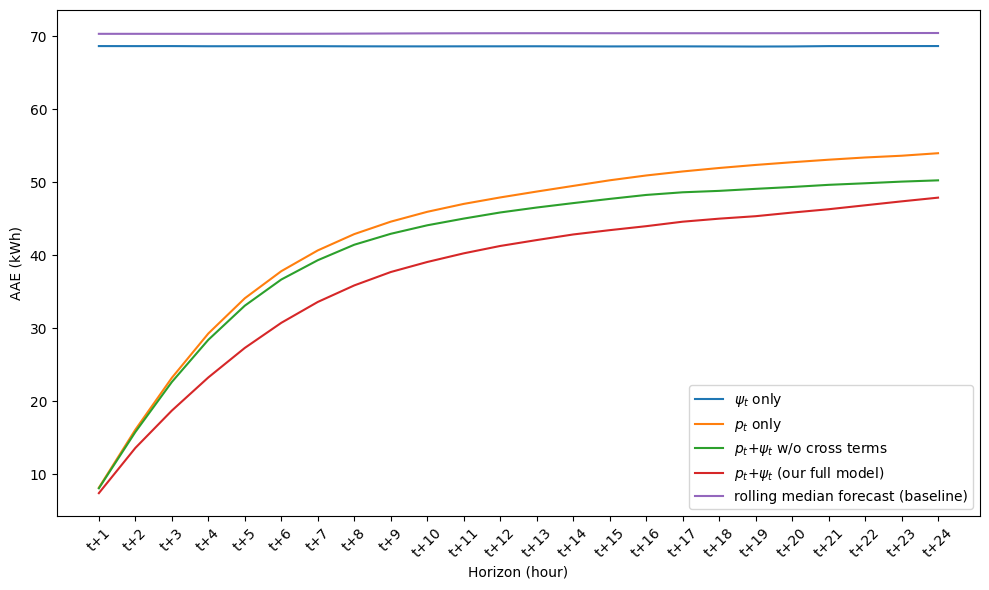

In [39]:
# Figure 4 of paper
colors = sns.color_palette("tab10", n_colors=5)
fig, ax = plt.subplots(figsize=(10,6))
x_ticks = [f"t+{i}" for i in range(1, 25)]
ax.plot(x_ticks, aaet_out, color=colors[0], label=r'$\psi_{t}$ only', linestyle="-")
ax.plot(x_ticks, aaep_out, color=colors[1], label=r'$p_{t}$ only', linestyle="-")
ax.plot(x_ticks, aaea_out, color=colors[2], label=r'$p_{t}$+$\psi_{t}$ w/o cross terms', linestyle="-")
ax.plot(x_ticks, aaec_out, color=colors[3], label=r'$p_{t}$+$\psi_{t}$ (our full model)', linestyle="-")
ax.plot(x_ticks, aaebaseline_out, color=colors[4], label='rolling median forecast (baseline)', linestyle="-")
ax.set_xticklabels(x_ticks, rotation=45)
ax.set_ylabel('AAE (kWh)')
ax.set_xlabel('Horizon (hour)')
ax.legend(loc="lower right")
plt.tight_layout()
plt.grid(False)
plt.savefig('aae.pdf')
plt.show()

In [33]:
quantiles = [0.02,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.98]
mask_in_sample = np.ones(mask_future_y_train_fwfill_std.shape, dtype=bool)
thetas_c = []
for q in quantiles:
    print(f"Solving for quantile: {q}")
    probc = problemc(future_y_in_sample_std, past_y_in_sample_stdc, mask_in_sample, K, q)
    probc.parameters()[0].value = [316.22776602,316.22776602,31.6227766]
    probc.parameters()[1].value = [10.0]
    start_time = time.time()
    probc.solve(verbose=False,solver=cp.MOSEK)
    end_time = time.time()
    print(f"Execution time: {end_time - start_time} seconds")
    thetac_q = probc.variables()[0].value
    thetas_c.append(thetac_q)

Solving for quantile: 0.02
Execution time: 179.55316376686096 seconds
Solving for quantile: 0.1
Execution time: 171.02721500396729 seconds
Solving for quantile: 0.2
Execution time: 175.53257393836975 seconds
Solving for quantile: 0.3
Execution time: 175.08527493476868 seconds
Solving for quantile: 0.4
Execution time: 171.50257897377014 seconds
Solving for quantile: 0.5
Execution time: 166.43591904640198 seconds
Solving for quantile: 0.6
Execution time: 169.30280923843384 seconds
Solving for quantile: 0.7
Execution time: 174.26800894737244 seconds
Solving for quantile: 0.8
Execution time: 175.92830395698547 seconds
Solving for quantile: 0.9
Execution time: 175.39414620399475 seconds
Solving for quantile: 0.98
Execution time: 179.88733911514282 seconds


In [34]:
thetas_a = []
for q in quantiles:
    print(f"Solving for quantile: {q}")
    proba = problema(future_y_in_sample_std, past_y_in_sample_stda, mask_in_sample, K, q)
    proba.parameters()[0].value = [316.22776602,316.22776602,31.6227766]
    proba.parameters()[1].value = [10.0]
    start_time = time.time()
    proba.solve(verbose=False,solver=cp.MOSEK)
    end_time = time.time()
    print(f"Execution time: {end_time - start_time} seconds")
    thetaa_q = proba.variables()[0].value
    thetas_a.append(thetaa_q)

Solving for quantile: 0.02
Execution time: 66.56419515609741 seconds
Solving for quantile: 0.1
Execution time: 64.32408285140991 seconds
Solving for quantile: 0.2
Execution time: 64.04105615615845 seconds
Solving for quantile: 0.3
Execution time: 63.78092694282532 seconds
Solving for quantile: 0.4
Execution time: 64.52976703643799 seconds
Solving for quantile: 0.5
Execution time: 62.510584115982056 seconds
Solving for quantile: 0.6
Execution time: 64.0156741142273 seconds
Solving for quantile: 0.7
Execution time: 63.68593192100525 seconds
Solving for quantile: 0.8
Execution time: 64.55181908607483 seconds
Solving for quantile: 0.9
Execution time: 64.98148703575134 seconds
Solving for quantile: 0.98
Execution time: 66.94617795944214 seconds


In [35]:
thetas_p = []
for q in quantiles:
    print(f"Solving for quantile: {q}")
    probp = problemp(future_y_in_sample_std, past_y_in_sample_stdp, mask_in_sample, q)
    probp.parameters()[0].value = [10.0]
    start_time = time.time()
    probp.solve(verbose=False,solver=cp.MOSEK)
    end_time = time.time()
    print(f"Execution time: {end_time - start_time} seconds")
    thetap_q = probp.variables()[0].value
    thetas_p.append(thetap_q)

Solving for quantile: 0.02
Execution time: 46.47124004364014 seconds
Solving for quantile: 0.1
Execution time: 45.847715854644775 seconds
Solving for quantile: 0.2
Execution time: 46.676472902297974 seconds
Solving for quantile: 0.3
Execution time: 46.1971218585968 seconds
Solving for quantile: 0.4
Execution time: 46.796871185302734 seconds
Solving for quantile: 0.5
Execution time: 45.070950746536255 seconds
Solving for quantile: 0.6
Execution time: 45.887317180633545 seconds
Solving for quantile: 0.7
Execution time: 45.86645793914795 seconds
Solving for quantile: 0.8
Execution time: 45.911014795303345 seconds
Solving for quantile: 0.9
Execution time: 46.175567865371704 seconds
Solving for quantile: 0.98
Execution time: 46.17569899559021 seconds


In [36]:
thetas_t = []
for q in quantiles:
    print(f"Solving for quantile: {q}")
    probt = problemt(future_y_in_sample_std, past_y_in_sample_stdt, mask_in_sample, K, q)
    probt.parameters()[0].value = [316.22776602,316.22776602,31.6227766]
    start_time = time.time()
    probt.solve(verbose=False,solver=cp.MOSEK)
    end_time = time.time()
    print(f"Execution time: {end_time - start_time} seconds")
    thetat_q = probt.variables()[0].value
    thetas_t.append(thetat_q)

Solving for quantile: 0.02
Execution time: 86.20845675468445 seconds
Solving for quantile: 0.1
Execution time: 85.87412714958191 seconds
Solving for quantile: 0.2
Execution time: 87.05446457862854 seconds
Solving for quantile: 0.3
Execution time: 86.86602807044983 seconds
Solving for quantile: 0.4
Execution time: 88.03355193138123 seconds
Solving for quantile: 0.5
Execution time: 84.97449803352356 seconds
Solving for quantile: 0.6
Execution time: 87.13130021095276 seconds
Solving for quantile: 0.7
Execution time: 89.04289507865906 seconds
Solving for quantile: 0.8
Execution time: 89.25183916091919 seconds
Solving for quantile: 0.9
Execution time: 89.22052097320557 seconds
Solving for quantile: 0.98
Execution time: 89.35792827606201 seconds


/var/folders/6q/k242kth90fb_ps_p32d_zx9r0000gn/T/ipykernel_26656/3765743604.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)


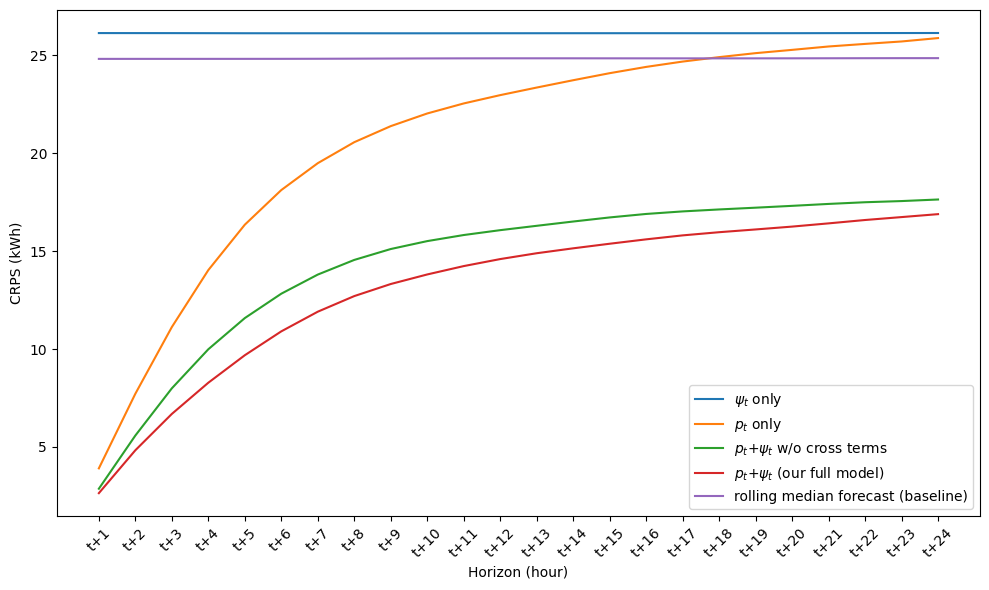

In [40]:
#Figure 8 of paper
def pinball_slopes(percentiles):
    percentiles=np.asarray(percentiles)
    a=(percentiles-50)*(0.01)
    b=(0.5)*np.ones((len(a),))
    return a,b

def crps_integral(quantiles,realization,percentiles):
    a, b = pinball_slopes(percentiles)
    nonnanindex = ~np.isnan(realization[:, 0])
    Var = realization[nonnanindex, 0].reshape(-1, 1) - quantiles[nonnanindex]
    obj = Var @ np.diag(a) + np.abs(Var) @ np.diag(b)
    quantiles = np.asarray(percentiles) / 100
    integrals = np.trapz(obj, quantiles, axis=1)
    return integrals

def calculate_crps(quantiles_unstd,future_unstd,percentiles):
    crps_unstd = np.zeros((quantiles_unstd.shape[0],quantiles_unstd.shape[1])) # number of samples by 24
    for i in range(quantiles_unstd.shape[0]): 
        crps_unstd[i] = crps_integral(quantiles_unstd[i],future_unstd[i].reshape(-1,1),percentiles)
    average_crps_unstd = np.mean(crps_unstd,axis=0)
    return average_crps_unstd

percentiles = [2,10,20,30,40,50,60,70,80,90,98]
actual = future_y_out_sample_std * sigma + mu
quantilesc = []
for i in range(len(quantiles)):
    quantilesc_q = (past_y_out_sample_stdc @ thetas_c[i]) * in_sample_standardization_std + in_sample_standardization_mean
    quantilesc.append(quantilesc_q)
quantilesa = []
for i in range(len(quantiles)):
    quantilesa_q = (past_y_out_sample_stda @ thetas_a[i]) * in_sample_standardization_std + in_sample_standardization_mean
    quantilesa.append(quantilesa_q)
quantilesp = []
for i in range(len(quantiles)):
    quantilesp_q = (past_y_out_sample_stdp @ thetas_p[i]) * in_sample_standardization_std + in_sample_standardization_mean
    quantilesp.append(quantilesp_q)
quantilest = []
for i in range(len(quantiles)):
    quantilest_q = (past_y_out_sample_stdt @ thetas_t[i]) * in_sample_standardization_std + in_sample_standardization_mean
    quantilest.append(quantilest_q)
quantilesbaseline = []
for i in range(len(quantiles)):
    forecasts_baseline = rolling_forecaster(past_baseline, percentile=percentiles[i])
    quantilesbaseline.append(forecasts_baseline)


quantilesc_concat = np.stack(quantilesc, axis=-1)
quantilesc_concat_sorted = np.sort(quantilesc_concat, axis=-1)

quantilesa_concat = np.stack(quantilesa, axis=-1)
quantilesa_concat_sorted = np.sort(quantilesa_concat, axis=-1)

quantilesp_concat = np.stack(quantilesp, axis=-1)
quantilesp_concat_sorted = np.sort(quantilesp_concat, axis=-1)

quantilest_concat = np.stack(quantilest, axis=-1)
quantilest_concat_sorted = np.sort(quantilest_concat, axis=-1)

quantilesbaseline_concat = np.stack(quantilesbaseline, axis=-1)
quantilesbaseline_concat_sorted = np.sort(quantilesbaseline_concat, axis=-1)


crpsc_out = calculate_crps(quantilesc_concat_sorted,future_y_out_sample_std * sigma + mu, percentiles)
crpsa_out = calculate_crps(quantilesa_concat_sorted,future_y_out_sample_std * sigma + mu, percentiles)
crpsp_out = calculate_crps(quantilesp_concat_sorted,future_y_out_sample_std * sigma + mu, percentiles)
crpst_out = calculate_crps(quantilest_concat_sorted,future_y_out_sample_std * sigma + mu, percentiles)
crpsbaseline_out = calculate_crps(quantilesbaseline_concat_sorted,future_baseline, percentiles)


colors = sns.color_palette("tab10", n_colors=7)
fig, ax = plt.subplots(figsize=(10,6))
x_ticks = [f"t+{i}" for i in range(1, 25)]
ax.plot(x_ticks, crpst_out, color=colors[0], label=r'$\psi_{t}$ only', linestyle="-")
ax.plot(x_ticks, crpsp_out, color=colors[1], label=r'$p_{t}$ only', linestyle="-")
ax.plot(x_ticks, crpsa_out, color=colors[2], label=r'$p_{t}$+$\psi_{t}$ w/o cross terms', linestyle="-")
ax.plot(x_ticks, crpsc_out, color=colors[3], label=r'$p_{t}$+$\psi_{t}$ (our full model)', linestyle="-")
ax.plot(x_ticks, crpsbaseline_out, color=colors[4], label='rolling median forecast (baseline)', linestyle="-")
ax.set_xticklabels(x_ticks, rotation=45)
ax.set_ylabel('CRPS (kWh)')
ax.set_xlabel('Horizon (hour)')
ax.legend(loc="lower right")
plt.tight_layout()
plt.grid(False)
plt.savefig('crps.pdf')
plt.show()

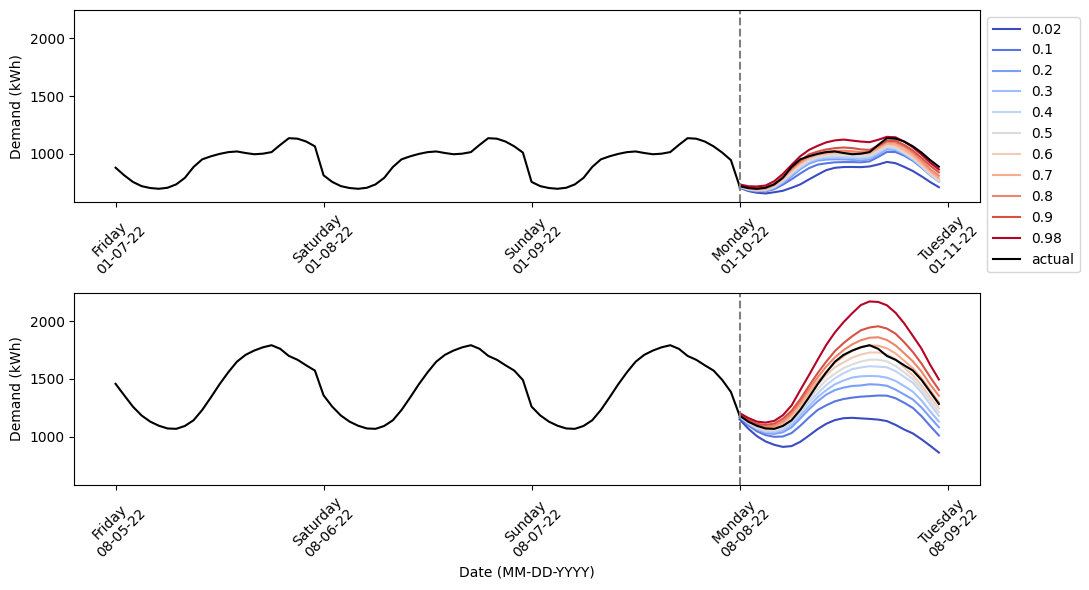

In [41]:
#Figure 9 of paper
from matplotlib.cm import coolwarm
i1 = int(24*9-24*3)
i2 = int(24*219-24*3)
xindex_first_half = range(48+24)
xindex_second_half = range(48+24,72+24)
sQ_data = quantilesc
future_y2_unstd_c = actual
quantile_labels = ["0.02", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "0.98"]
colors = [coolwarm(i) for i in np.linspace(0, 1, len(quantile_labels))]
fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharey=True)
def plot_estimates(ax, i, sQ_data):
    for j in range(11): 
        estimate = np.hstack([future_y2_unstd_c[i-3],future_y2_unstd_c[i-2], future_y2_unstd_c[i-1], sQ_data[j][i]])
        ax.plot(xindex_second_half, estimate[48+24:], color=colors[j], label=f"{quantile_labels[j]}" if i == i1 else "")
    actual = np.hstack([future_y2_unstd_c[i-3],future_y2_unstd_c[i-2], future_y2_unstd_c[i-1], future_y2_unstd_c[i]])
    ax.plot(actual, color="black", label="actual" if i == i1 else "")
    ax.grid(False)
    ax.axvline(48+24, color='gray', linestyle='--')
plot_estimates(axes[0], i1, sQ_data)
plot_estimates(axes[1], i2, sQ_data)
dates_labels = [["Friday\n01-07-22", "Saturday\n01-08-22", "Sunday\n01-09-22", "Monday\n01-10-22", "Tuesday\n01-11-22"],
                ["Friday\n08-05-22", "Saturday\n08-06-22", "Sunday\n08-07-22", "Monday\n08-08-22", "Tuesday\n08-09-22"]]
c = 0
for idx, ax in enumerate(axes):
    ax.set_xticks([0, 24, 48, 72, 96])
    ax.set_xticklabels(dates_labels[c], rotation=45, ha="center")
    c+=1
axes[-1].set_xlabel("Date (MM-DD-YYYY)")
axes[0].set_ylabel("Demand (kWh)")
axes[1].set_ylabel("Demand (kWh)")
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
fig.savefig('marginal_quantile_forecasts.pdf')
plt.show()